In [1]:
import sys
sys.path.insert(1, '../positron/')
import numpy as np
from sklearn.datasets import load_breast_cancer
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

data = load_breast_cancer()
print(data["DESCR"])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

### Load data to numpy arrays

In [2]:
X = np.array(data.data)
y = np.array([data.target]).T
print("Loading in the data")
print("X =", X.shape, "y =", y.shape)

Loading in the data
X = (569, 30) y = (569, 1)


### Preprocess data for the neural network

In [3]:
import prep
y = prep.one_hot_encode(y)
print(y)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


### Visualize data

In [4]:
df = pd.DataFrame(np.c_[X, y], columns=list(data["feature_names"]) + list(data["target_names"]))
print(data["feature_names"], data["target_names"])
df.head()

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension'] ['malignant' 'benign']


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,malignant,benign
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1.0,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1.0,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1.0,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1.0,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1.0,0.0


<AxesSubplot:>

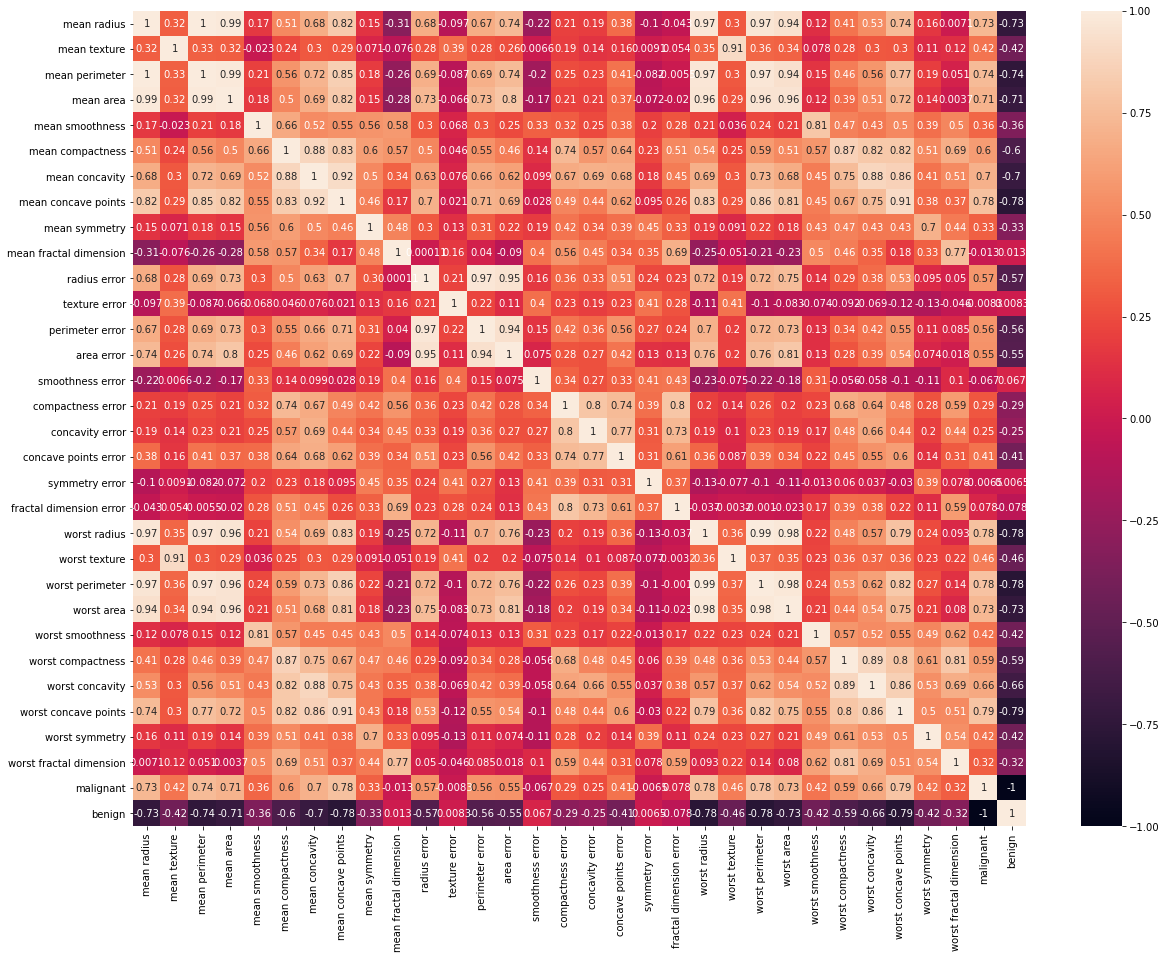

In [5]:
fig = plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), annot=True)

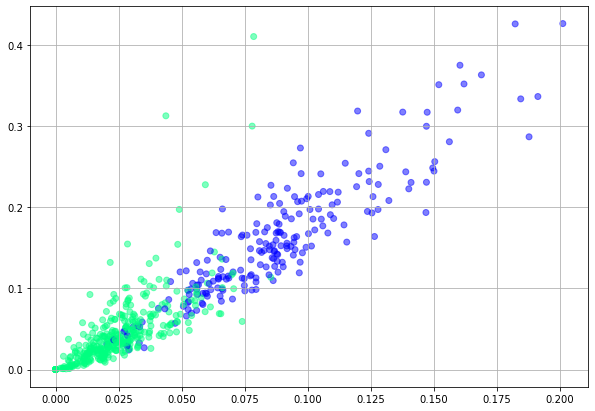

In [6]:
fig = plt.figure(figsize=(10, 7))
plt.grid()
plt.scatter(df["mean concave points"], df["mean concavity"], c=df["benign"], marker="o", alpha=0.5, cmap=plt.cm.winter)
plt.show()

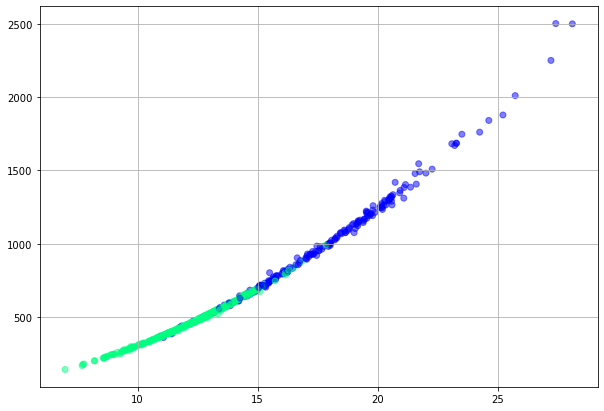

In [7]:
fig = plt.figure(figsize=(10, 7))
plt.grid()
plt.scatter(df["mean radius"], df["mean area"], c=df["benign"], marker="o", alpha=0.5, cmap=plt.cm.winter)
plt.show()

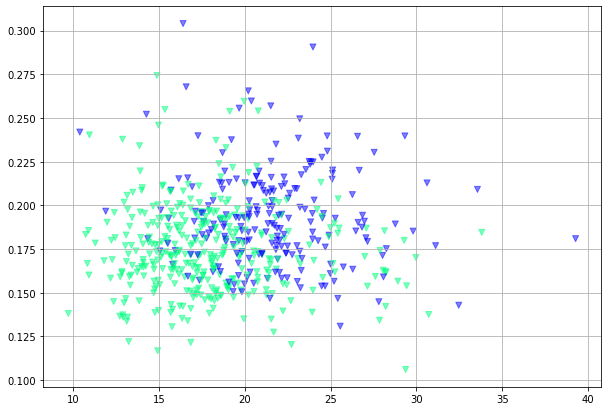

In [8]:
fig = plt.figure(figsize=(10, 7))
plt.grid()
plt.scatter(df["mean texture"], df["mean symmetry"], c=df["benign"], marker="v", alpha=0.5, cmap=plt.cm.winter)
plt.show()

### Get training/test data

In [9]:
from sklearn.impute import SimpleImputer

# Relpace missing values if there are
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp_mean.fit_transform(X)

xtrain, xtest, ytrain, ytest = prep.split_train_test(X, y, shuffle=True)
for _ in (xtrain, xtest, ytrain, ytest,):
    print(_.shape, end=" ")

(512, 30) (57, 30) (512, 2) (57, 2) 

### Creating the network for all features

In [10]:
import deep

layer_sizes = [30, 30, 2]
layer_activ = ["sigmoid", "sigmoid", "binary_step"]
deep.seed(0)
ws, bs = deep.init_network(X.shape[1], layer_sizes)
print(layer_sizes, layer_activ)

[30, 30, 2] ['sigmoid', 'sigmoid', 'binary_step']


### Train the network

In [11]:
import score


weights, biases, cost_history = deep.SGD(
    xtrain, ytrain,
    ws, bs,
    activations=layer_activ,
    costf="mse",
    eta=1.0,
    epochs=1000,
    mini_batch_size=1,
    verbose=True,
    cost_history_needed=False)
o = deep.feedforward(xtest, weights, biases, layer_activ)
print("Accuracy", 100 * round((np.sum(score.mse(o, ytest)) / np.sum(y)), 2), "% for", len(ytest), "samples")

Training: 100%|██████████| 1000/1000 [00:17<00:00, 57.00 ep/s]

Accuracy 5.0 % for 57 samples
